<a href="https://colab.research.google.com/github/xli2522/simple-BBH-waveform/blob/main/simple_BBH_waveform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt

##1. Merger Frequency Ranges of BBH Systems

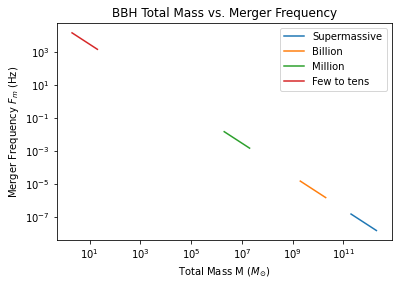

[[1.4604595344127507e-07, 1.460459534412751e-08], [1.4604595344127508e-05, 1.4604595344127509e-06], [0.014604595344127507, 0.001460459534412751], [14604.595344127509, 1460.4595344127508]]


In [22]:
# Frequency ranges of BBH mergers
def fmerger(M):
    '''Calculates the merger freuqency of a BBH system given the total mass M of the system
    '''
    c = 3*10**8           # speed of light
    G = 6.674*10**(-11)   # gravitational constant
    R = 1.7               # compactness ratio
    freq = (2*c**3)/(R**(3/2)*G*M*1.989*10**30)/(2*np.pi)     # merger frequency formula

    return freq

# Calculate the frequency ranges of 
ranges = []; masses = []
# 1. Supermassive 10**11 Msolar
Mmin = 2*10**11; Mmax = 2*10**12
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 2. Billion Msolar
Mmin = 2*10**9; Mmax = 2*10**10
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 3. Million Msolar
Mmin = 2*10**6; Mmax = 2*10**7
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 4. Few to tens Msolar
Mmin = 2; Mmax = 20
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])

for i in range(len(ranges)):
    plt.plot(masses[i], ranges[i])
plt.legend(['Supermassive', 'Billion','Million', 'Few to tens'])
plt.title('BBH Total Mass vs. Merger Frequency')
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'Total Mass M ($M_{\odot}$)')
plt.ylabel(r'Merger Frequency $F_m$ (Hz)')
plt.show()

print(ranges)

##2. Individual Mass Estimation of GW150914

In [1]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'

     |████████████████████████████████| 27.3 MB 6.6 MB/s 
     |████████████████████████████████| 6.3 MB 30.0 MB/s 
     |████████████████████████████████| 51 kB 2.6 MB/s 
     |████████████████████████████████| 1.4 MB 43.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 201 kB 53.0 MB/s 
     |████████████████████████████████| 75 kB 2.4 MB/s 
     |████████████████████████████████| 295 kB 52.2 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 3.6 MB 35.9 MB/s 


###2.1 Obtain GW150914 Data from LIGO Database

In [9]:
%matplotlib inline
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

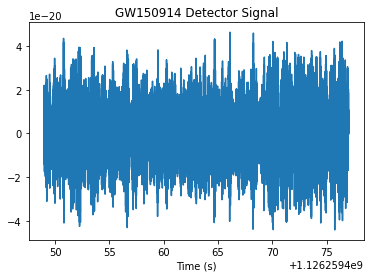

In [24]:
merger = Merger("GW150914")

# Get the data from H and L detectors
hdata = merger.strain('H1')
ldata = merger.strain('L1')

# Frequency pass filter and downsample the data to 2048Hz 
# (normally 4096Hz is used but in this simple calculation the sampling Freq can be lower)
hdata = highpass(hdata, 15.0)
hdata = resample_to_delta_t(hdata, 1.0/2048)

ldata = highpass(ldata, 15.0)
ldata = resample_to_delta_t(ldata, 1.0/2048)

# crop the signal
conditionedhdata = hdata.crop(2, 2); conditionedldata = ldata.crop(2, 2)
pylab.plot(conditionedhdata.sample_times, conditionedhdata)
pylab.xlabel('Time (s)')
pylab.title('GW150914 Detector Signal')
pylab.show()

In [30]:
# Here are some steps taken to reduce the further reduce the signal noise

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density
psdh = conditionedhdata.psd(4); psdl = conditionedldata.psd(4)       # take the first 4 seconds of data and calculate the psd
psdh = interpolate(psdh, conditionedhdata.delta_f); psdl = interpolate(psdl, conditionedldata.delta_f)       # interpolate the resutl to the proper length
psdh = inverse_spectrum_truncation(psdh, int(4 * conditionedhdata.sample_rate), low_frequency_cutoff=15)
psdl = inverse_spectrum_truncation(psdl, int(4 * conditionedldata.sample_rate), low_frequency_cutoff=15)

In [31]:
# Here are some Signal to Noise (SNR) and merger time data avaliable on GW150914
# we skip the calculation here
snrp = 19.677089013145903
time = 1126259462.4248047

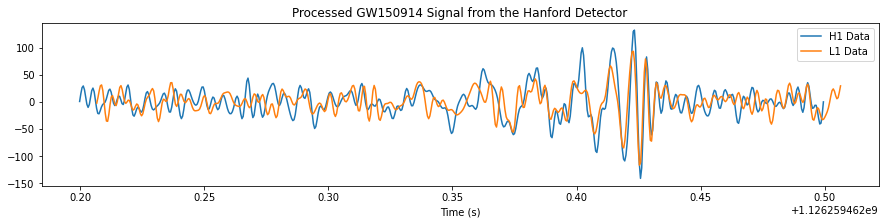

In [37]:
# Data whitening as a step of denoising
white_hdata = (conditionedhdata.to_frequencyseries() / psdh**0.5).to_timeseries()
white_ldata = (conditionedldata.to_frequencyseries() / psdl**0.5).to_timeseries()

# Apply high pass and low pass (frequency) filter again
white_hdata = white_hdata.highpass_fir(30., 512).lowpass_fir(300, 512)
white_ldata = white_ldata.highpass_fir(30., 512).lowpass_fir(300, 512)

# Select the time around the merger (0.2 s before, 0.1 s after)
white_hdata = white_hdata.time_slice(merger.time-.2, merger.time+.1)
white_ldata = white_ldata.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.title('Processed GW150914 Signal from the Hanford Detector')
pylab.plot(white_hdata.sample_times, white_hdata, label="H1 Data")
# Here we invert the L1 data and shift L1 data forward by 6.9 ms to match the t_merger
pylab.plot(white_ldata.sample_times+0.0069, -white_ldata, label="L1 Data")
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

### 2.2 Estimate Instantaneous Frequencies (IFs)

In [47]:
# Though we can adopt the method of counting 0-crossings to estimate the IFs
# To simplify the process, we use time-frequency decomposition method like the S transform to estimate the IFs
! pip install -q 'TFchirp==0.0.2'

/usr/local/lib/python3.7/dist-packages/scipy/signal/windows/windows.py:1277: RuntimeWarning: divide by zero encountered in true_divide
  w = np.exp(-n ** 2 / sig2)
/usr/local/lib/python3.7/dist-packages/scipy/signal/windows/windows.py:1277: RuntimeWarning: invalid value encountered in true_divide
  w = np.exp(-n ** 2 / sig2)


(151, 615)


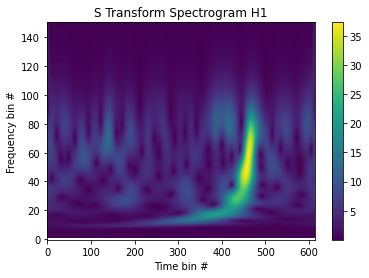

In [135]:
import TFchirp
spectrogramh = abs(TFchirp.sTransform(white_hdata, sample_rate=2048))
print(spectrogramh.shape)

plt.imshow(spectrogramh, origin='lower', aspect='auto')
plt.title('S Transform Spectrogram H1')
plt.xlabel('Time bin #')
plt.ylabel('Frequency bin #')
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/signal/windows/windows.py:1277: RuntimeWarning: divide by zero encountered in true_divide
  w = np.exp(-n ** 2 / sig2)
/usr/local/lib/python3.7/dist-packages/scipy/signal/windows/windows.py:1277: RuntimeWarning: invalid value encountered in true_divide
  w = np.exp(-n ** 2 / sig2)


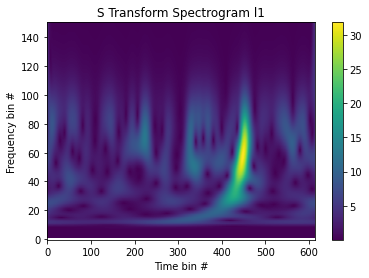

In [136]:
spectrograml = abs(TFchirp.sTransform(white_ldata, sample_rate=2048))
plt.imshow(spectrograml, origin='lower', aspect='auto')
plt.title('S Transform Spectrogram l1')
plt.xlabel('Time bin #')
plt.ylabel('Frequency bin #')
plt.colorbar()
plt.show()

In [ ]:
# The IFs are 

###2.3 Time Evolution of Orbital Frequency

####Appendix:

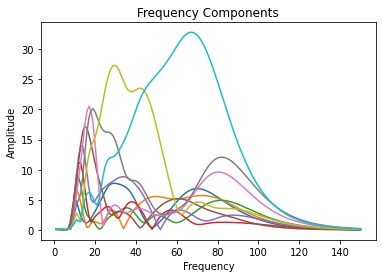

[29, 11, 12, 12, 13, 15, 17, 19, 30, 67]


In [130]:
# sample the signal with a constant time interval 
# from 200 time bin to 500 time bin 
samplesh = []          
for i in range(200, 500, 30):
    # only a limited number of elements, use python list for simplicity
    samplesh.append(spectrogramh[:,i])
    plt.plot(spectrogramh[:,i])
plt.title('Frequency Components')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

# now collect peak frequencies (under the assumption that peak frequencies are the IFs of the BBH merger signal)
peaksh = []
for count in range(len(samplesh)):
    peaksh.append(int(np.where(samplesh[count] == max(samplesh[count][1:]))[0]))
print(peaksh)

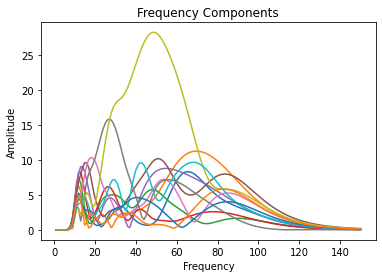

[65, 70, 12, 13, 14, 51, 18, 27, 49, 68, 40, 83]


In [133]:
# sample the signal with a constant time interval 
# from 200 time bin to 500 time bin 
samplesl = []          
for i in range(200, 560, 30):
    # only a limited number of elements, use python list for simplicity
    samplesl.append(spectrograml[:,i])
    plt.plot(spectrograml[:,i])
plt.title('Frequency Components')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

# now collect peak frequencies (under the assumption that peak frequencies are the IFs of the BBH merger signal)
peaksl = []
for count in range(len(samplesl)):
    peaksl.append(int(np.where(samplesl[count] == max(samplesl[count][1:]))[0]))
print(peaksl)

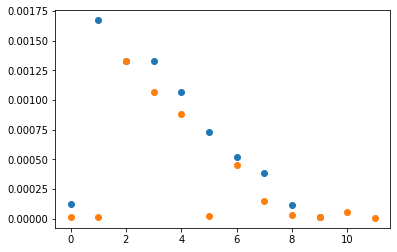

In [134]:
# plot the IF diagram
peaksh = np.asarray(peaksh); peaksl = np.asarray(peaksl)
rescaledh = peaksh**(-8/3); rescaledl = peaksl**(-8/3)
plt.scatter(range(len(rescaledh)), rescaledh); plt.scatter(range(len(rescaledl)), rescaledl)
plt.show()